# BCycle Austin models

This notebook concludes the BCycle Austin series of blog posts, and looks at how machine learning could be used to help the BCycle team. I'll be using weather data in addition to the station and bike information, and building models which I hope might be useful. Let's get started !

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

import datetime

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading weather and rental data


In [2]:
bikes_df = load_bikes()
stations_df = load_stations()
weather_df = load_weather()

# Modelling bike rentals by day

In this section, I'll be using machine learning to predict how many bike rentals there are in each day. As this is a time series problem, I'll split the dataset as follows. This gives roughly a 70% training - 30% validation data split.

* Training: 1st April to 15th May (6 complete weeks of data).
* Validation: 16th May to 31st May (2 complete weeks of data).

I'll create a couple of simple baselines first, which just use previous rental numbers directly. If our machine learning models can't beat this, there's a problem! After that, I'll use time-series forecasting, and then linear regression.

In [3]:
# First create a daily rentals dataframe, split it into training and validation
rentals_df = load_daily_rentals()
train_df = rentals_df['2016-04-01':'2016-05-15']
val_df = rentals_df['2016-05-16':'2016-05-31']

print('\nTraining data head:\n{}'.format(train_df.head()))
print('\nValidation data head:\n{}'.format(val_df.head()))


Training data head:
            rentals
date               
2016-04-01    353.0
2016-04-02    853.0
2016-04-03    818.0
2016-04-04    525.0
2016-04-05    563.0

Validation data head:
            rentals
date               
2016-05-16    503.0
2016-05-17    405.0
2016-05-18    540.0
2016-05-19    273.0
2016-05-20    847.0


# Baseline - predict daily rentals using median

To start off with, let's just predict the median amount of checkouts in the training dataset, and see how the RMSE looks. This is the most basic prediction we can make.

In [4]:
median_train_df = train_df.copy()
train_median = median_train_df['rentals'].median()

median_val_df = val_df.copy()
median_train_df['pred'] = train_median
median_val_df['pred'] = train_median

## Helper functions

Let's define some helper functions, which are used in the code below. We'll be running these steps multiple times for each model, so it saves copying and pasting.

In [5]:
def RMSE(pred, true):
    '''
    Calculates Root-Mean-Square-Error using predicted and true
    columns of pandas dataframe
    INPUT: pred and true pandas columns
    RETURNS: float of RMSE
    '''
    rmse = np.sqrt(np.sum((pred - true).apply(np.square)) / pred.shape[0])
    return rmse

def plot_prediction(df, pred_col, true_col, title):
    '''
    Plots the predicted rentals along with actual rentals for the dataframe
    INPUT: df - pandas dataframe containing predicted and true columns
           pred_col - string with prediction column name
           true_col - string with actual column name
    RETURNS: Nothing
    '''
    fig, ax = plt.subplots(1,1, figsize=(18,10))
    ax = df.plot(y=[pred_col, true_col], ax=ax, color='black', style=['--', '-'])
    ax.set_xlabel('Date', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
#     ax.set_xticklabels(df.index.strftime('%a %b %d'))

Now we can evaluate how the median baseline performs in terms of RMSE. We use the training dataset to compute the median, and then evaluate on the validation set. 

Median baseline RMSE - Train: 188.31, Val: 275.72


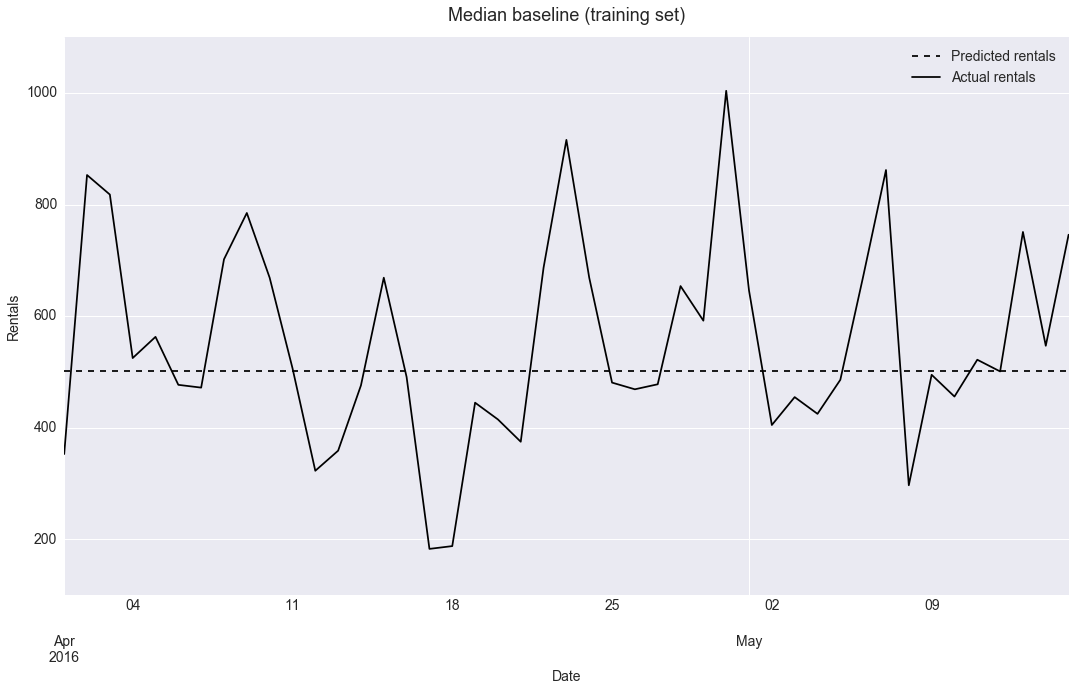

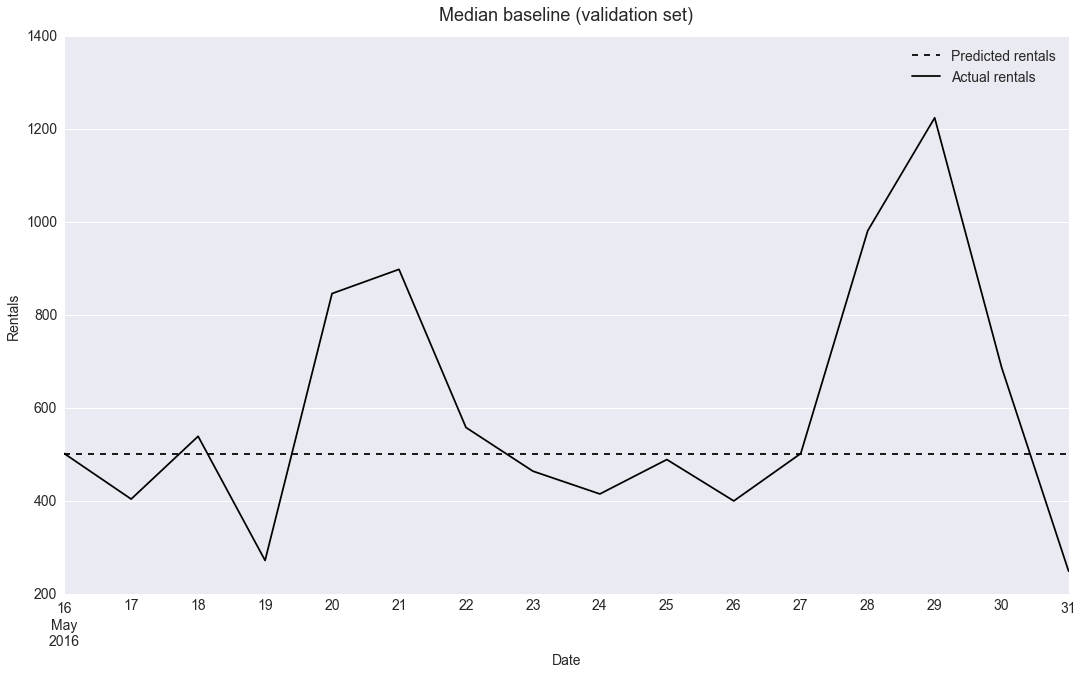

In [6]:
# Store the results of the median RMSE and plot prediction
median_train_rmse = RMSE(median_train_df['pred'], median_train_df['rentals'])
median_val_rmse = RMSE(median_val_df['pred'], median_val_df['rentals'])

# Store the evaluation results
scores = dict() # Store the model scores in here
scores['median_train_rmse'] = median_train_rmse
scores['median_val_rmse'] = median_val_rmse

# Print out the RMSE metrics and the prediction
print('Median baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(median_train_rmse, median_val_rmse))
plot_prediction(median_train_df, 'pred', 'rentals', title='Median baseline (training set)')
plot_prediction(median_val_df, 'pred', 'rentals', title='Median baseline (validation set)')

By predicting the median amount of rentals for each day, we end up with an RMSE of 276. This means on average in each of the days we're 275 bikes off the actual rental amount. You can see on the plot the static line doesn't track the daily variations in rentals. What if we take the median for each day independently ..?

# Baseline - predict daily rentals using median for day-of-week

To improve on the previous fixed median baseline, we can calculate the median rentals for each day separately in the training set. Then for the days in the test set, use the median computed for that day-of-the week. This captures the daily variation in rentals, as well as the weekend and weekday differences.

In [7]:
# Calculate the median amount of checkouts by day of week from the training data
dow_med_df = train_df.copy()
dow_med_df = dow_med_df.reset_index()
dow_med_df['dayofweek'] = dow_med_df['date'].dt.dayofweek
dow_med_df = dow_med_df.groupby('dayofweek').median().reset_index()
dow_med_df

,dayofweek,rentals
0,0,488.0
1,1,455.5
2,2,451.0
3,3,481.0
4,4,671.0
5,5,853.0
6,6,669.0


In [8]:
# Use the day-of-week to combine predictions and calculate difference in training set
dow_train_df = train_df.copy()
dow_train_df = dow_train_df.reset_index()
dow_train_df['dayofweek'] = dow_train_df['date'].dt.dayofweek
dow_train_df = pd.merge(dow_train_df, dow_med_df, on='dayofweek', how='left', suffixes=('_true', '_pred'))
dow_train_df['diff'] = dow_train_df['rentals_pred'] - dow_train_df['rentals_true']
dow_train_df.index = dow_train_df['date']
dow_train_df = dow_train_df.drop(['date', 'dayofweek'], axis=1)
dow_train_df.head()

,rentals_true,rentals_pred,diff
date,,,
2016-04-01,353.0,671.0,318.0
2016-04-02,853.0,853.0,0.0
2016-04-03,818.0,669.0,-149.0
2016-04-04,525.0,488.0,-37.0
2016-04-05,563.0,455.5,-107.5


In [10]:
# Use the day-of-week to join the predictions into the validation set, and calculate difference
dow_val_df = val_df.copy()
dow_val_df = dow_val_df.reset_index()
dow_val_df['dayofweek'] = dow_val_df['date'].dt.dayofweek
dow_val_df = pd.merge(dow_val_df, dow_med_df, on='dayofweek', how='left', suffixes=('_true', '_pred'))
dow_val_df['diff'] = dow_val_df['rentals_pred'] - dow_val_df['rentals_true']
dow_val_df.index = dow_val_df['date']
dow_val_df = dow_val_df.drop(['date', 'dayofweek'], axis=1)
dow_val_df.head()

,rentals_true,rentals_pred,diff
date,,,
2016-05-16,503.0,488.0,-15.0
2016-05-17,405.0,455.5,50.5
2016-05-18,540.0,451.0,-89.0
2016-05-19,273.0,481.0,208.0
2016-05-20,847.0,671.0,-176.0


Now we have predictions for each of the days in the validation set, we can calculate our error metric (Root-Mean-Square-Error) and plot our predictions to see how we did with the simplistic baseline.

Median baseline RMSE - Train: 146.14, Val: 184.63


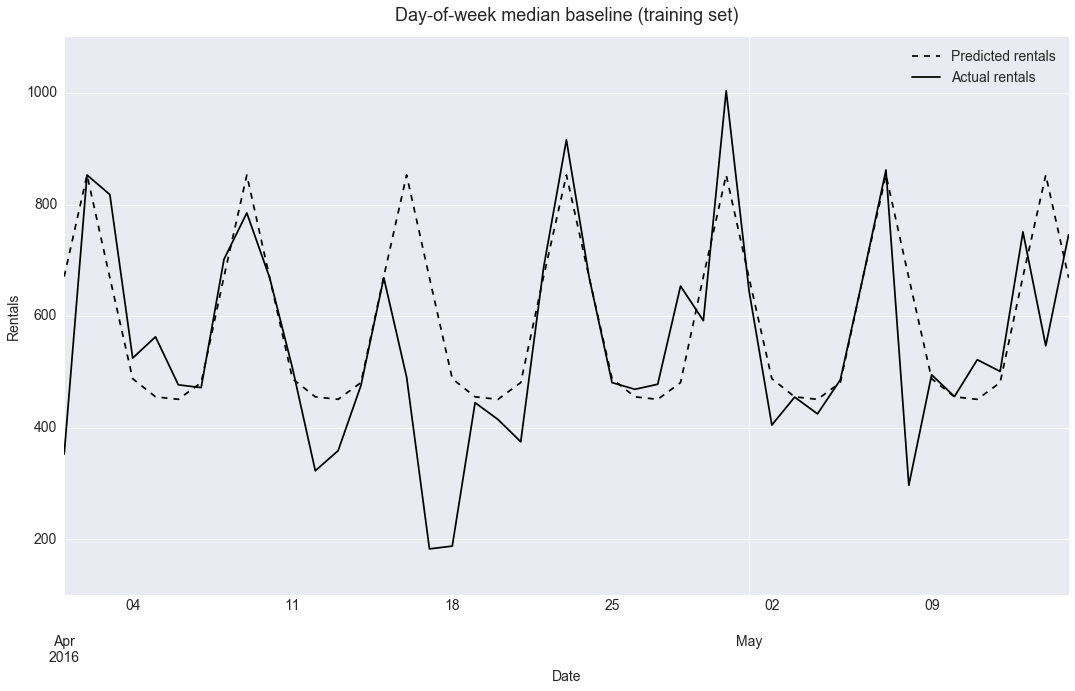

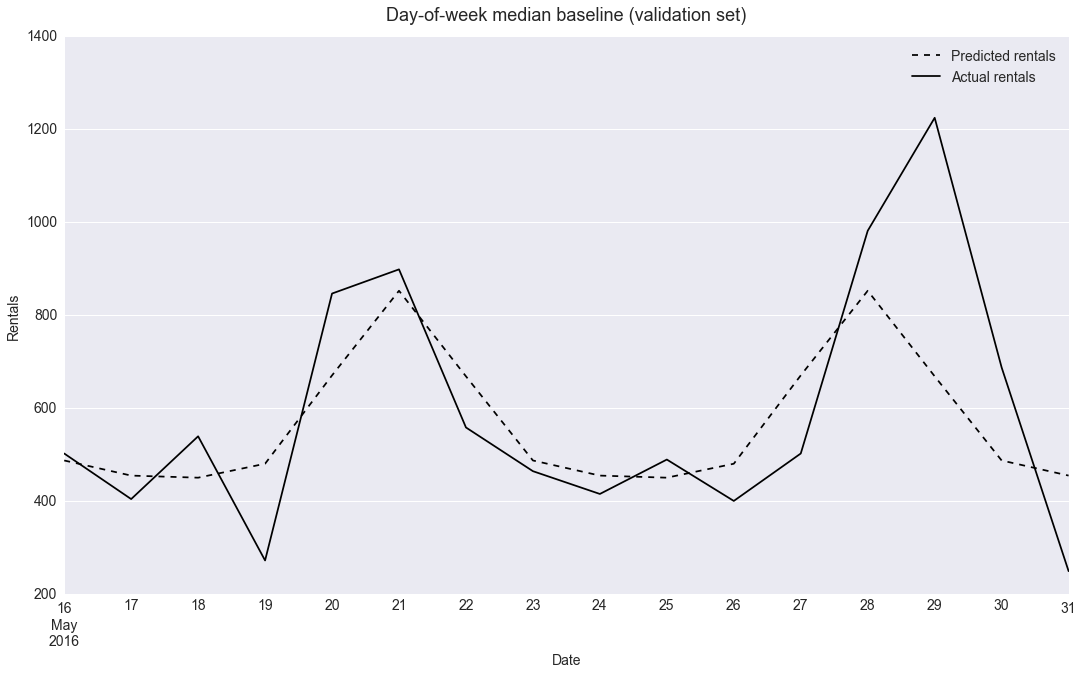

In [11]:
# Store the results of the median RMSE and plot prediction
dow_train_rmse = RMSE(dow_train_df['rentals_pred'], dow_train_df['rentals_true'])
dow_val_rmse = RMSE(dow_val_df['rentals_pred'], dow_val_df['rentals_true'])

# Store the evaluation results
scores = dict() # Store the model scores in here
scores['dow_train_rmse'] = dow_train_rmse
scores['dow_val_rmse'] = dow_val_rmse

# Print out the RMSE metrics and the prediction
print('Median baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(dow_train_rmse, dow_val_rmse))
plot_prediction(dow_train_df, 'rentals_pred', 'rentals_true', title='Day-of-week median baseline (training set)')
plot_prediction(dow_val_df, 'rentals_pred', 'rentals_true', title='Day-of-week median baseline (validation set)')

The RMSE for the baseline prediction is 185. This shows that each day, we're off by an average of 185 bikes using this simple benchmark. This is a big improvement on the static median value which had an RMSE of 275. The plot of the prediction shows the daily variation matches well with the observed data. The biggest gap is during the Memorial Day weekend at the end of May.

# Linear models - Time

Now we have some baselines to compare against, let's use a [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) model to predict the daily rentals in the last couple of weeks of the validation dataset. We'll be using the excellent [scikit-learn](http://scikit-learn.org/stable/) library, which has a wide range of [linear models](http://scikit-learn.org/stable/modules/linear_model.html) we can use. First of all, let's create some helper functions.

* `add_date_features`: Adds some extra variables:
    * `dayofweek`: An ordinal variable for day of week. This is converted to one-hot by `reg_x_ysplit`.
    * `weekend`: A boolean to show whether this day is the weekend or weekday.
    * `prev_rentals`: The amount of rentals the day before.
    * `prev_week_rentals`: The amount of rentals on this day, the week before.
    
    
* `reg_x_y_split`: Converts the dataframe into X (input features) and y (output prediction values).

In [12]:
from sklearn import preprocessing

# First let's add some features to help the model out
def add_date_features(input_df):
    '''Adds day-of-week, weekend, and lagged rentals (day and week)
    INPUT: Dataframe with datetime index
    RETURNS: Copy of dataframe with extra features
    '''
    df = input_df.copy()
    df = df.reset_index()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekend'] = df['dayofweek'] < 5
    df['prev_rentals'] = df['rentals'].shift(+1)
    df.loc[0, 'prev_rentals'] = df.loc[0, 'rentals']
    df['prev_week_rentals'] = df['rentals'].shift(+7)
    df.loc[0:6, 'prev_week_rentals'] = df.loc[0:6, 'rentals']
    return df

def reg_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    
    # Split target and features
    X = np.hstack((df[['weekend', 'prev_rentals']].values, dayofweek))
    y = df['rentals'].values

    return X, y

Now we can use the helper functions to create the X and y numpy arrays for use in the machine learning models

In [13]:
# Create new time-based features, numpy arrays to train model
reg_train_df = add_date_features(train_df)
reg_val_df = add_date_features(val_df)

X_train, y_train = reg_x_y_split(reg_train_df)
X_val, y_val = reg_x_y_split(reg_val_df)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (45, 9), y_train shape: (45,)
X_val shape: (16, 9), y_val shape: (16,)


Now we can train the model, make predictions, and calculate the RMSE of the predictions. scikit-learn has a built in Mean-Square-Error function, so we can square-root this to get RMSE.

In [14]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['reg_train_rmse'] = reg_train_rmse
scores['reg_val_rmse'] = reg_val_rmse

print('Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

Regression RMSE - Train: 131.71, Val: 205.92


Now let's create another helper function, which takes all the model predictions and stores them in a common dataframe format we can re-use in many steps

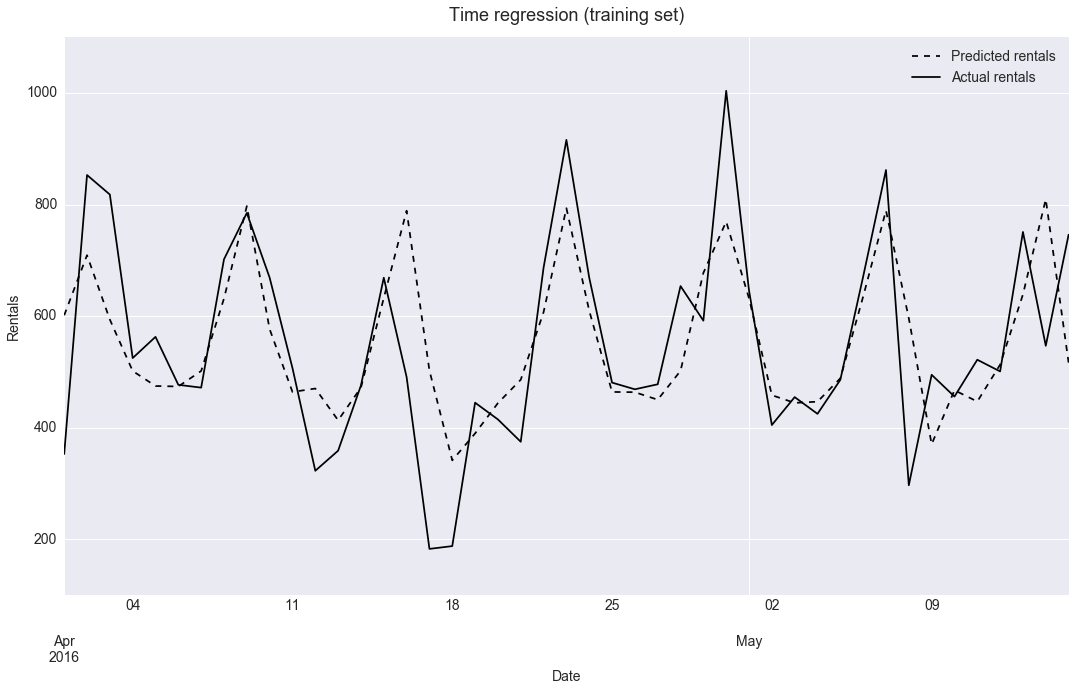

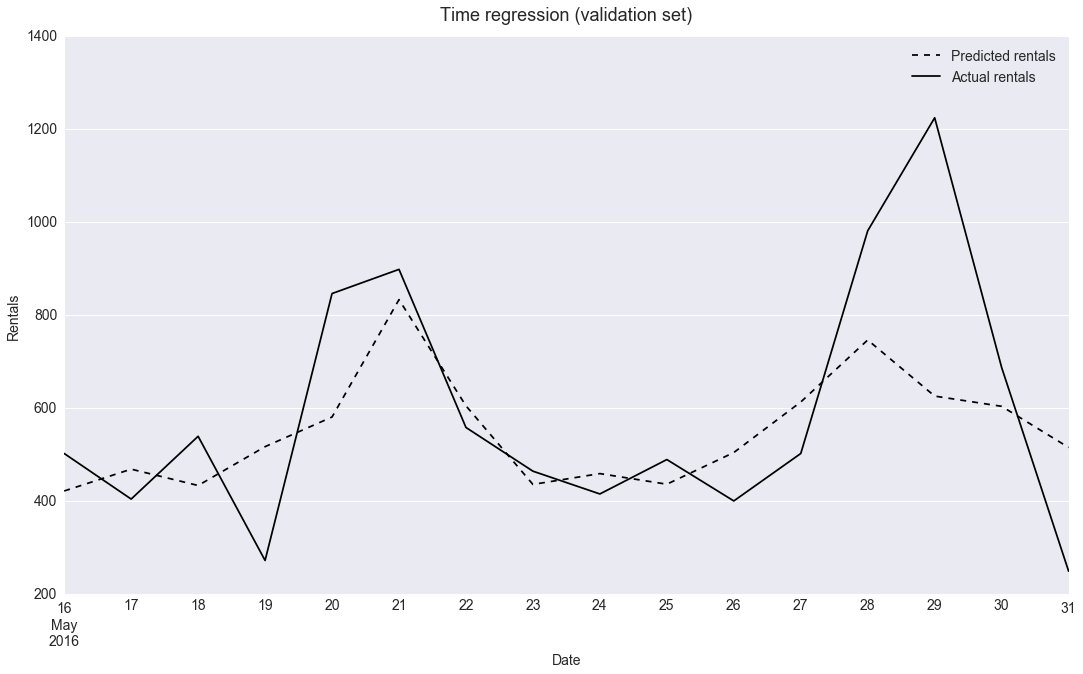

In [15]:
def df_from_results(index_train, y_train, y_train_pred, index_val, y_val, y_val_pred):
    
    train_dict = dict()
    val_dict = dict()

    train_dict['true'] = y_train
    train_dict['pred'] = y_train_pred

    val_dict['true'] = y_val
    val_dict['pred'] = y_val_pred

    train_df = pd.DataFrame(train_dict)
    val_df = pd.DataFrame(val_dict)

    train_df.index = index_train
    val_df.index = index_val
    
    return train_df, val_df
    
reg_result_train_df, reg_result_val_df = df_from_results(reg_train_df['date'], y_train, y_train_pred,
                                                         reg_val_df['date'], y_val, y_val_pred)

plot_prediction(reg_result_train_df, 'pred', 'true', title='Time regression (training set)')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Time regression (validation set)')

# Linear Models - Time and Weather

To improve on the previous results, we can use the weather conditions to give the model extra information. First of all, we can do a naive approach and merge in all weather data to see how this changes the performance of the model.

In [16]:
# Merge the training and validation datasets with the weather dataframe
train_weather_df = pd.merge(train_df, weather_df, left_index=True, right_index=True)
val_weather_df = pd.merge(val_df, weather_df, left_index=True, right_index=True)

# Add date features, drop the date field itself
train_weather_df = add_date_features(train_weather_df)
val_weather_df = add_date_features(val_weather_df)

train_weather_df = train_weather_df.drop('date', axis=1)
val_weather_df = val_weather_df.drop('date', axis=1)

This helper function splits the weather-based dataframe into X and y as before. Now we can see there are 26 features in the training and validation sets, compared to 9 with the basic time-based model.

In [17]:
def reg_weather_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    df_index = df.columns[0]
    df = df.reset_index()
    df.drop(df_index, axis=1)
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    # Split target and features
    X = np.hstack((df.drop('rentals', axis=1).values, dayofweek))
    y = df['rentals'].values

    return X, y

X_train, y_train = reg_weather_x_y_split(train_weather_df)
X_val, y_val = reg_weather_x_y_split(val_weather_df)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (45, 26), y_train shape: (45,)
X_val shape: (16, 26), y_val shape: (16,)


Weather Regression RMSE - Train: 89.60, Val: 205.82


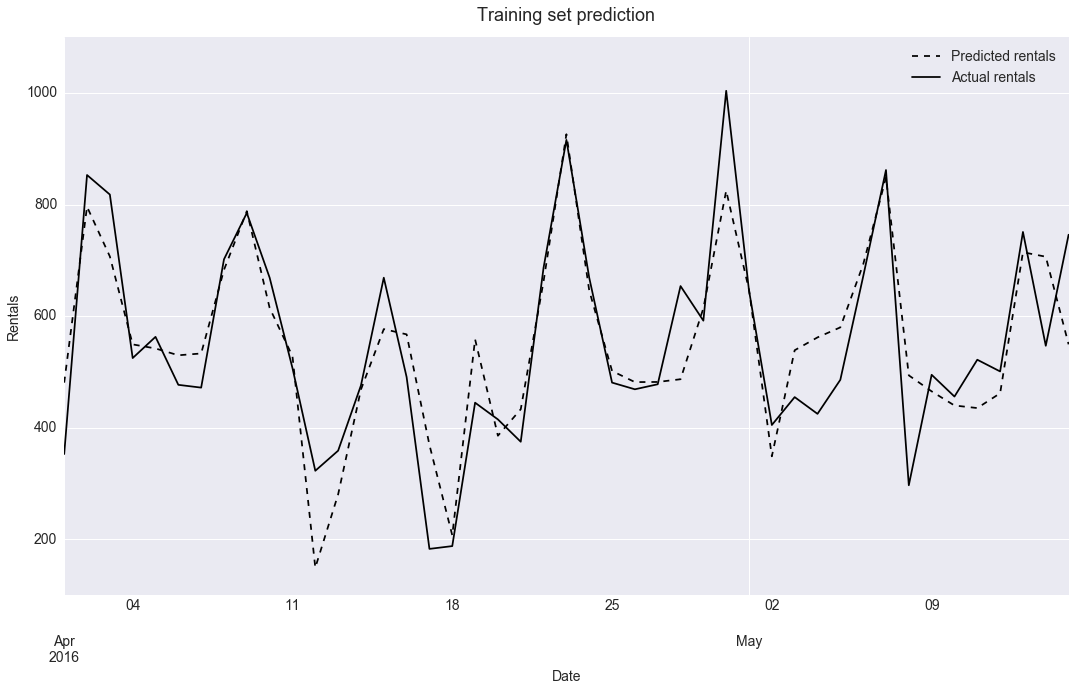

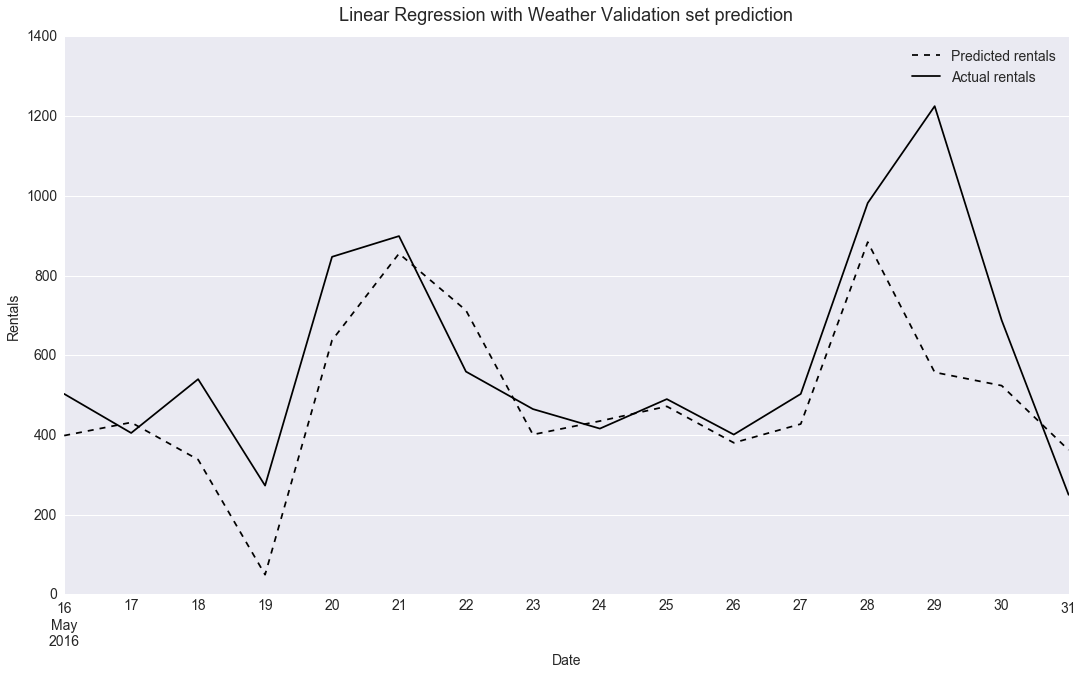

In [18]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['weather_reg_train_rmse'] = reg_train_rmse
scores['weather_reg_val_rmse'] = reg_val_rmse

print('Weather Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')

The results are pretty surprising. Our new fancy model with loads of weather performs better on the training data (RMSE of 90 vs 131). The validation score didn't change (RMSE of 205.8 vs 205.9). The validation set performance is actually worse then the day-of-week median baseline ! This is called **overfitting**. Overfitting is when a model performs well on the training set, but doesn't generalise to new data. 

The answer is that more data (especially for linear models) is not always better. If certain features are correlated with each other, then this can confuse the model when it's trained. There are also assumptions about the statistics of the input data (that each feature comes from a Gaussian process, which are independent and identically distributed). If we violate this assumptions the model won't perform well.

# Linear Models - Time and Weather with Feature Engineering

The results of the linear models with time and weather show a case of overfitting. The training set RMSE is 90 which is better than all other models so far. But the validation set shows a much worse RMSE of 205. This is worse than the baseline day-of-week median model !

Before addressing the overfitting, we need to remove features which are highly correlated with each other. To make sure we don't cheat by checking the validation set distribution, we'll only use the training set.

The weather correlation plots are shown in the `bcycle_weather` notebook separately. After removing weather columns which are highly correlated with each other, we can plot their correlation with the target variable (checkouts). Our intuition can help as well.

* rentals
* max_temp
* min_temp
* max_gust
* precipitation
* cloud_pct
* rain
* thunderstorm



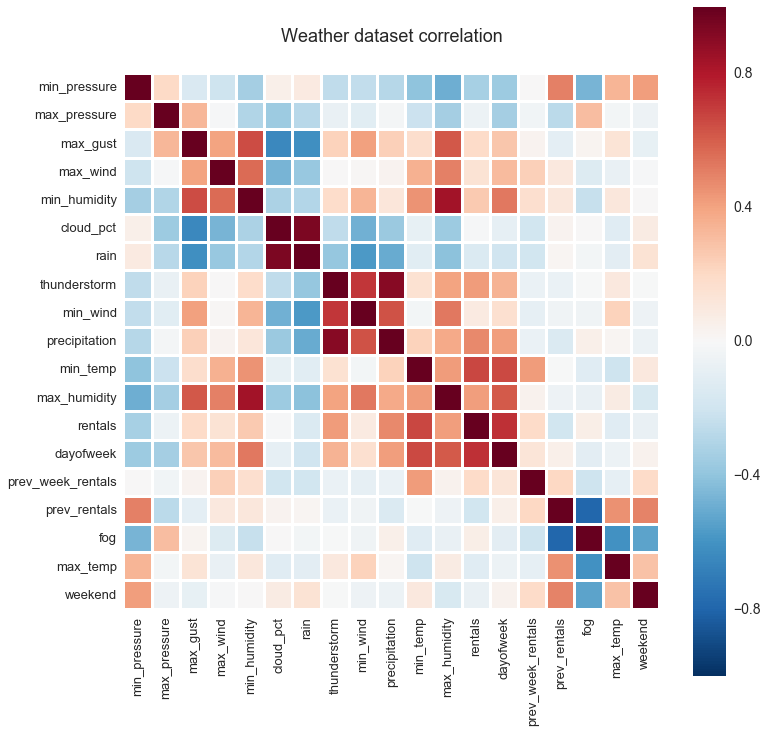

In [84]:
corr_df = train_weather_df.corr()

max_corr_cols = (corr_df - np.eye(corr_df.shape[0])).max(axis=0)
max_corr_cols = max_corr_cols.sort_values(axis=0, ascending=False)

corr_df.columns = max_corr_cols.index
corr_df.index = max_corr_cols.index

fig, ax = plt.subplots(1,1, figsize=(12, 12))
sns.heatmap(data=corr_df, square=True, linewidth=2, linecolor='white', ax=ax)
ax.set_title('Weather dataset correlation', fontdict={'size' : 18})
ttl = ax.title
ttl.set_position([.5, 1.05])
# ax.set_xlabel('Week ending (Sunday)', fontdict={'size' : 14})
# ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

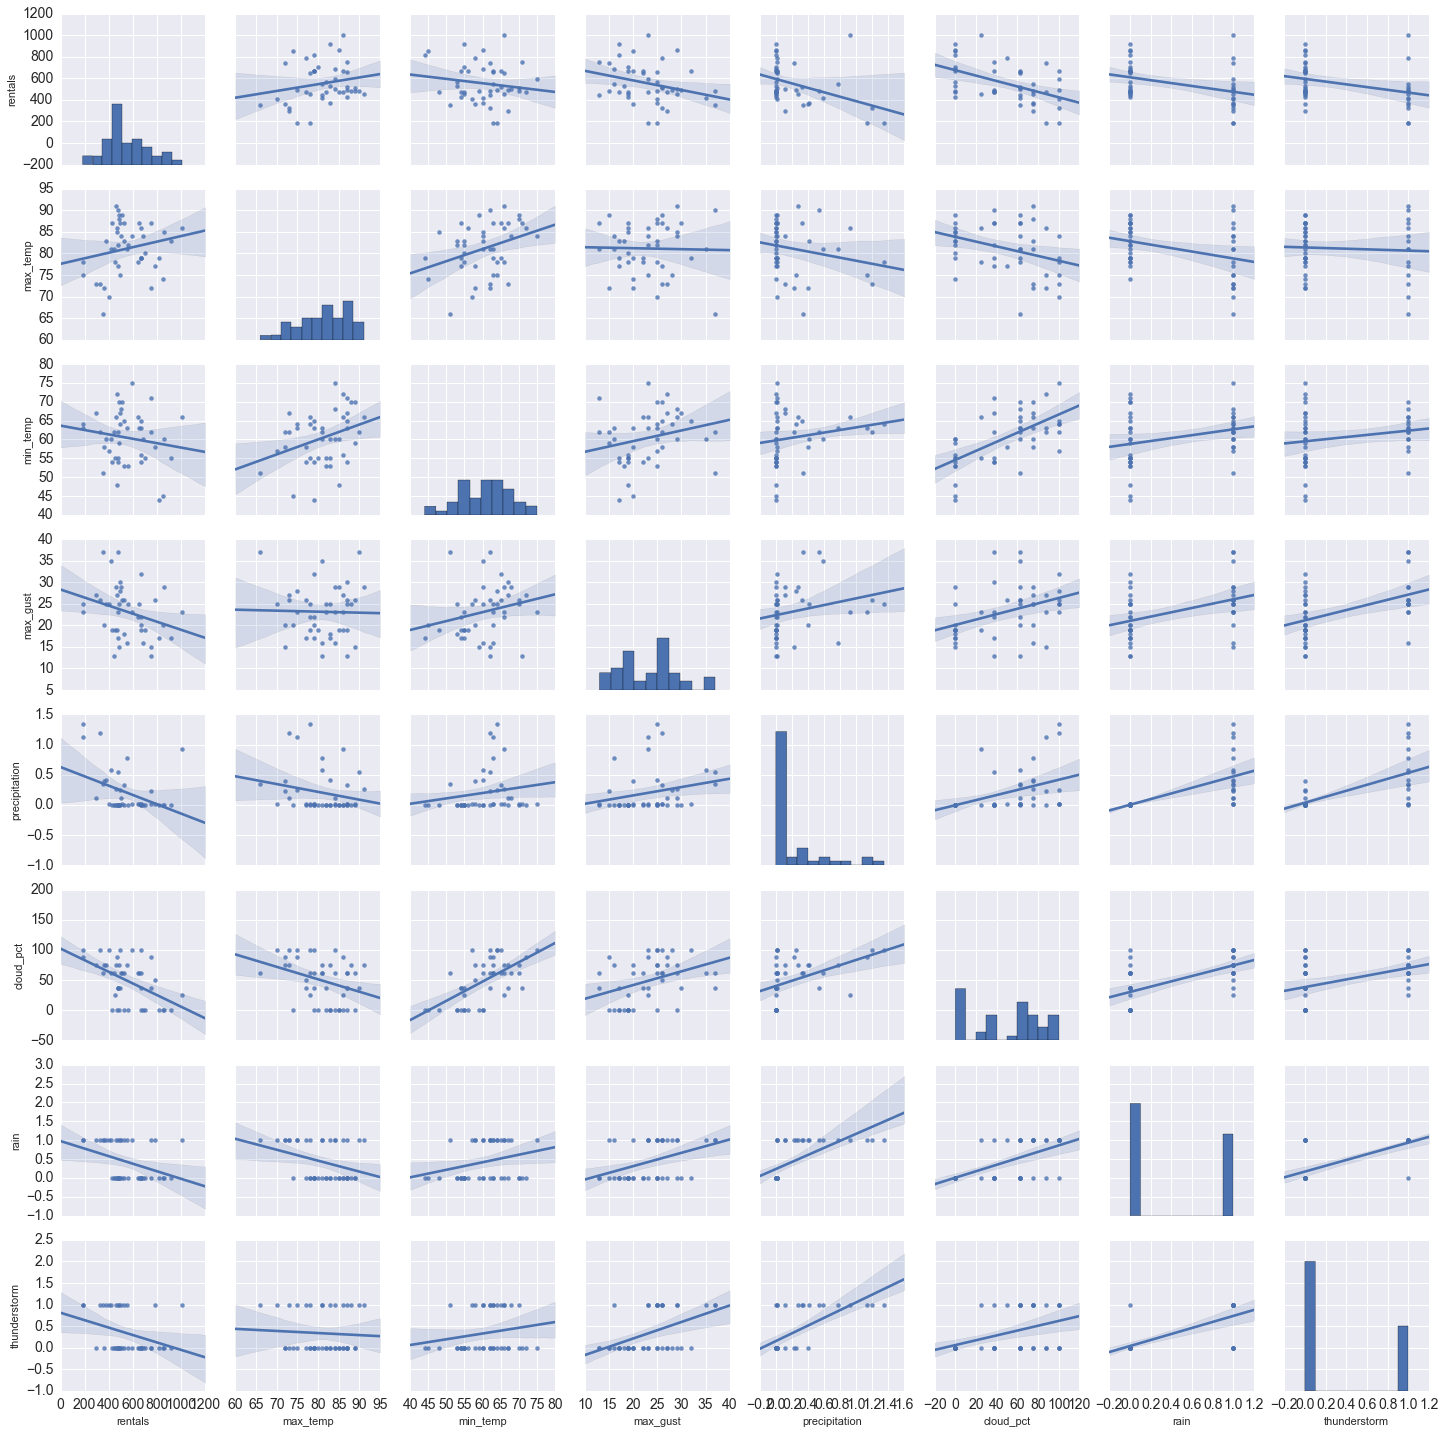

In [79]:
# Check correlation of the weather features and rentals. May take a minute to compute as there are a lot.
sns.pairplot(train_weather_df[['rentals', 'max_temp', 'min_temp', 'max_gust', 'precipitation', 
         'cloud_pct', 'rain', 'thunderstorm']], kind='reg')


# train_weather_df.columns

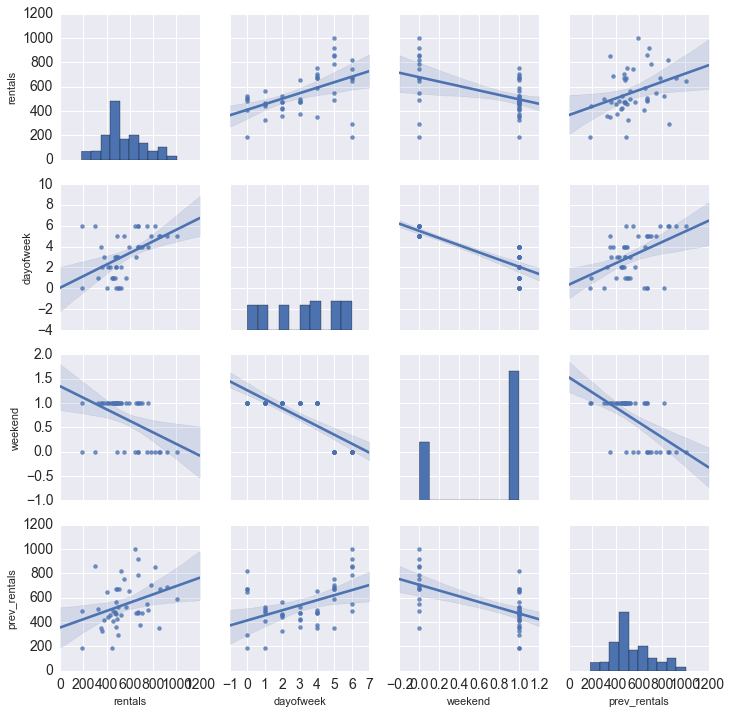

In [20]:
# Check correlation of the time-based features and rentals. May take a minute to compute as there are a lot.
sns.pairplot(train_weather_df[['rentals', 'dayofweek', 'weekend', 'prev_rentals']], kind='reg')


# train_weather_df.columns

In [85]:
def reg_weather_feat_x_y_split(df, features=None):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    
    if features is not None:
        df = df[features]
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    # Split target and features
    X = np.hstack((df.drop('rentals', axis=1).values, dayofweek))
    y = df['rentals'].values

    return X, y

cols = ['rentals', 'max_temp', 'min_temp', 'max_gust', 'precipitation', 
        'cloud_pct', 'thunderstorm', 'dayofweek', 'weekend', 'prev_rentals']

X_train, y_train = reg_weather_feat_x_y_split(train_weather_df, features=cols)
X_val, y_val = reg_weather_feat_x_y_split(val_weather_df, features=cols)

print('X_train columns: {}'.format(train_weather_df.columns))
print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train columns: Index(['rentals', 'max_temp', 'min_temp', 'max_humidity', 'min_humidity',
       'max_pressure', 'min_pressure', 'max_wind', 'min_wind', 'max_gust',
       'precipitation', 'cloud_pct', 'thunderstorm', 'rain', 'fog',
       'dayofweek', 'weekend', 'prev_rentals', 'prev_week_rentals'],
      dtype='object')
X_train shape: (45, 16), y_train shape: (45,)
X_val shape: (16, 16), y_val shape: (16,)


Weather Feature Regression RMSE - Train: 95.59, Val: 159.63


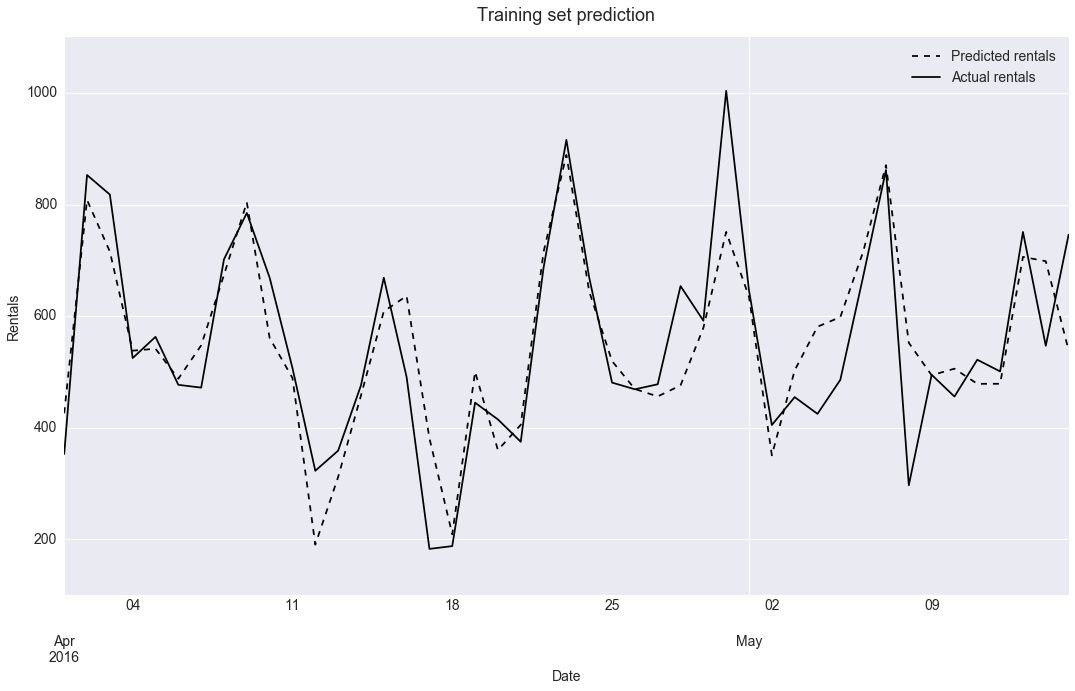

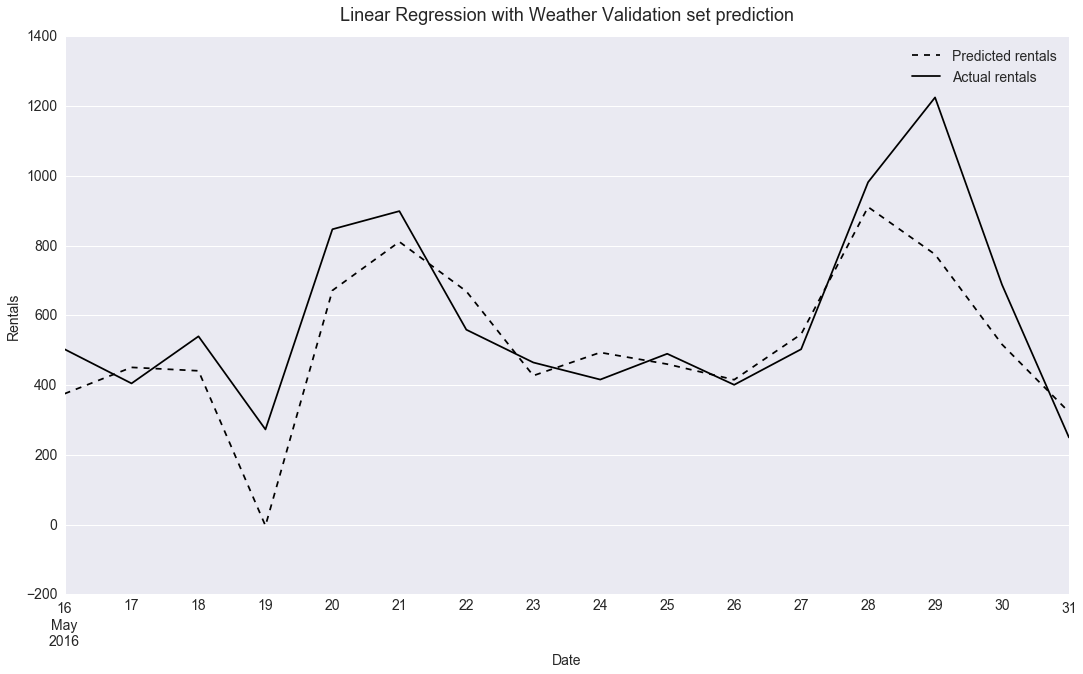

In [86]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_weather_feat_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_weather_feat_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['weather_reg_feat_train_rmse'] = reg_weather_feat_train_rmse
scores['weather_reg_feat_val_rmse'] = reg_weather_feat_val_rmse

print('Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_weather_feat_train_rmse, reg_weather_feat_val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')

With feature selection, we've managed to improve on the median day-of-week baseline. The training RMSE increased from 90 to 95, but the validation RMSE decreased from 206 to 160. The day-of-week median was 185 for reference.  This shows the performance of the model increased as fewer features were correlated with each other, and also fewer features gave less overfitting.

In [88]:
scores

{'dow_train_rmse': 146.14152197251966,
 'dow_val_rmse': 184.62694650294145,
 'reg_train_rmse': 131.71384098587532,
 'reg_val_rmse': 205.91635061814662,
 'weather_reg_feat_train_rmse': 95.588699355539546,
 'weather_reg_feat_val_rmse': 159.63404624644113,
 'weather_reg_train_rmse': 89.595751818286473,
 'weather_reg_val_rmse': 205.81750260962201}

# Linear Models - Model Tuning

Now the features seem to be in good shape, we can try some different models to see which gives the best results.

,alpha,train_rmse,test_rmse
0,0.01,95.589002,159.491083
1,0.10,95.616245,158.354273
2,1.00,96.951461,154.374122
3,10.00,108.498662,163.976743


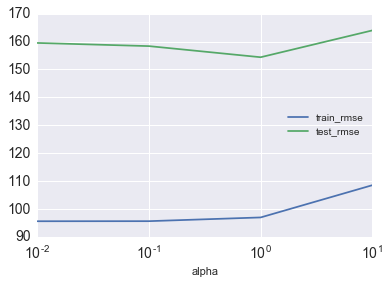

In [89]:
from sklearn.linear_model import Ridge

alphas = [0.01, 0.1, 1.0, 10.0]
ridge_cv_scores = dict()

for alpha in alphas:
    reg = Ridge(alpha=alpha, max_iter=10000)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    ridge_cv_scores[alpha] = (train_rmse, val_rmse)

ridge_cv_df = pd.DataFrame(ridge_cv_scores).transpose().reset_index()
ridge_cv_df.columns = ['alpha', 'train_rmse', 'val_rmse']
ridge_cv_df.plot.line(x='alpha', y=['train_rmse', 'val_rmse'], logx=True)
ridge_cv_df

,alpha,train_rmse,test_rmse
0,0.01,95.588753,159.598990
1,0.10,95.594086,159.297815
2,1.00,96.063884,157.169208
3,10.00,112.992442,171.941348


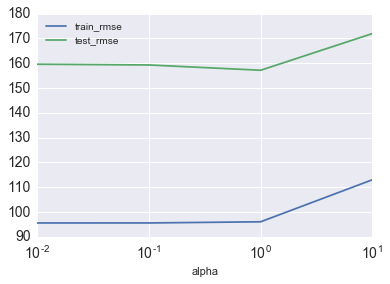

In [83]:
from sklearn.linear_model import Lasso

alphas = [0.01, 0.1, 1.0, 10.0]
ridge_cv_scores = dict()

for alpha in alphas:
    reg = Lasso(alpha=alpha, max_iter=10000)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    ridge_cv_scores[alpha] = (train_rmse, val_rmse)

lasso_cv_df = pd.DataFrame(ridge_cv_scores).transpose().reset_index()
lasso_cv_df.columns = ['alpha', 'train_rmse', 'test_rmse']
lasso_cv_df.plot.line(x='alpha', y=['train_rmse', 'test_rmse'], logx=True)
lasso_cv_df

# Linear Models - Review

So far we've done the following:

* Created a very basic baseline (median checkouts). This has an RMSE of 276 on the validation set.
* Improved the basic baseline (median checkouts by day of week). This RMSE is 185 on the validation data.
* Created and tuned a linear model using weather information. This RMSE is 164 on validation data.

So with the best model we have, we're off by 164 bikes per day, on average. This isn't great .. What's going on?

* We don't have very much data. By aggregating across all 50 stations, grouping by day, we end up with only 45 training examples to learn from and 16 to validate on. This is a very small amount of data to learn from, ideally we should have 1000s of examples.

* The Memorial Day holiday also causes issues for the model, because it hasn't seen one of these in the training dataset. If we had a year's worth of data to train from, we could use a dummy variable that is set to 1 on the holiday. We could also use a dummy variable for the weekend before the holiday, to flag these days up to the model.

How can we improve things? More data !

* Build individual models for each station. This increases the compute by 50x (there are 50 stations), but each of the 50 models has the same data as our single model.
* Add interaction terms and bin features



In [ ]:
# Create 50 separate models, and aggregate the results (still daily by station)

# First, take the original bikes_df and group it by station_id and then date 
daily_stations_df = load_bike_trips()
daily_stations_df = daily_stations_df.reset_index()
daily_stations_df['date'] = daily_stations_df['datetime'].dt.date
daily_stations_df = daily_stations_df[['date', 'station_id', 'checkouts']]
daily_stations_df = daily_stations_df.groupby(['date', 'station_id']).sum().reset_index()

# Merge the date and weather features
daily_stations_df = add_date_features(daily_stations_df)

# daily_stations_df.index

# train_weather_df = pd.merge(train_df, weather_df, left_index=True, right_index=True)
# val_weather_df = pd.merge(val_df, weather_df, left_index=True, right_index=True)

# train_weather_df = add_date_features(train_weather_df)
# val_weather_df = add_date_features(val_weather_df)

# train_weather_df = train_weather_df.drop('date', axis=1)
# val_weather_df = val_weather_df.drop('date', axis=1)

# models = list()
# for station in daily_stations_df['station_id'].unique():
#     day_df = daily_stations_df[daily_stations_df['station_id']] == station
    


# daily_stations_df[daily_stations_df['station_id'] == 1]

daily_stations_df

# reg = LinearRegression()
# reg.fit(X_train, y_train)
# y_train_pred = reg.predict(X_train)
# reg_weather_feat_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# y_val_pred = reg.predict(X_val)
# reg_weather_feat_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# scores['weather_reg_feat_train_rmse'] = reg_weather_feat_train_rmse
# scores['weather_reg_feat_val_rmse'] = reg_weather_feat_val_rmse

# print('Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_weather_feat_train_rmse, reg_weather_feat_val_rmse))

# reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
#                                                          val_df.index, y_val, y_val_pred)

# plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
# plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')



In [ ]:
daily_stations_df.info()


In [ ]:
val_train_df